# Case Study 1 : Collecting Data from Twitter

Due Date: September 22, **before the beginning of class at 6:00pm**

* ------------

<img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/9f/Twitter_bird_logo_2012.svg/220px-Twitter_bird_logo_2012.svg.png">

**TEAM Members:**

    Matthew Beaulieu
    
    Yousef Fadila
    
    Meng Li
    
    Monica Tlachac
    
---

**Required Readings:** 
* Chapter 1 and Chapter 9 of the book [Mining the Social Web](http://www.learndatasci.com/wp-content/uploads/2015/08/Mining-the-Social-Web-2nd-Edition.pdf) 
* The codes for [Chapter 1](http://bit.ly/1qCtMrr) and [Chapter 9](http://bit.ly/1u7eP33)


** NOTE **
* Please don't forget to save the notebook frequently when working in IPython Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem 1: Sampling Twitter Data with Streaming API about a certain topic

* Select a topic that you are interested in, for example, "WPI" or "Lady Gaga"
* Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million.
* Store the tweets you downloaded into a local file (txt file or json file) 

In [4]:
import pandas as pd
import matplotlib
import warnings
import json
import numpy as np
import wikiwords
from tweepy import Stream
from tweepy.streaming import StreamListener
import pymongo
import tweepy
import re
from prettytable import PrettyTable
from collections import Counter

warnings.simplefilter(action = "ignore", category = FutureWarning)
%matplotlib inline
#---------------------------------------------
# Define a Function to Login Twitter API
#
# XXX  - DON'T COMMIT TRUE CREDINTIALS TO GITHUB
CONSUMER_KEY = 'k01qrrsDSOHdjUObbt1pWjhld'
CONSUMER_SECRET ='FTBSa4UU5Nxaw00hNPJQvoAf60HinJM87GfQpuFM0YsVKDdoJD'
OAUTH_TOKEN = '4229853605-mSgVKfVSZ9BSN7GbPgvUIPOT1Xl6F3nA2ynKMvy'
OAUTH_TOKEN_SECRET = 'jyHtNVKGmqNw4HyBLMYG5i9BT3junKGVFnY6CE2tjJRFW'

# mango db auth.
MANGODB_SERVER = 'ds033046.mlab.com'
MANGODB_PORT = 33046
MANGODB_USER = 'ds501u'
MANGODB_PASS = 'ds501p'
MANGODB_NAME = 'ds501case1'
MANGODB_COLLECTION = 'tweets'
GEOBOX_USA = [-125,25.1,-60.5,49.1]
us_states = ["WA" , "DE" , "WI" , "WV" , "HI" , "FL" , "WY" , "NH" , "NJ" , "NM" , "TX" , "LA" , "NC" , "ND" , "NE" , "TN" , "NY" , "PA" , "CA" , "NV" , "VA" , "CO" , "AK" , "AL" , "AR" , "VT" , "IL" , "GA" , "IN" , "IA" , "OK" , "AZ" , "ID" , "CT" , "ME" , "MD" , "MA" , "OH" , "UT" , "MO" , "MN" , "MI" , "RI" , "KS" , "MT" , "MS" , "SC" , "KY" , "OR" , "SD" ] 
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

db_client = pymongo.MongoClient(MANGODB_SERVER, MANGODB_PORT)
db = db_client[MANGODB_NAME]
db.authenticate(MANGODB_USER, MANGODB_PASS)
tweets_Collection = db[MANGODB_COLLECTION]
# Global functions defs----------------------------------------------
def print_top_entities(label, entities, max_to_show):
    pt = PrettyTable(field_names=[label, 'Count'])
    c = Counter(entities)
    [ pt.add_row(kv) for kv in c.most_common()[:max_to_show] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)


In [2]:
class MyListener(StreamListener):
    def __init__(self, max_count = 100):
        self.count = 0
        self.max_count = max_count   
        self.collection = db[MANGODB_COLLECTION]

    def on_data(self, data):
        try:
            if self.count >= self.max_count:
                return False
            # the question require output to file. so output to file and save in mangoDB
            with open('data/hillary.json', 'a') as f:
                f.write(data)
            self.count = self.count + 1
            datajson = json.loads(data)
            self.collection.insert_one(datajson)
            return True
        except BaseException as e:
            print(e)
        return True
 
    def on_error(self, status):
        print(status)
        return True
    
api = tweepy.API(auth)
limit = 15000
twitter_stream = Stream(auth, MyListener(limit))
twitter_stream.filter(track=['@HillaryClinton'], languages=["en"], locations=GEOBOX_USA)
print("streaming done")


streaming done


### Report some statistics about the tweets you collected 

* The topic of interest: Hillary Clinton                   


* The total number of tweets collected:  ~15000

# Problem 2: Analyzing Tweets and Tweet Entities with Frequency Analysis

**1. Word Count:** 
* Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets. 
* Plot a table of the top 30 words with their counts

**Getting Text from Tweets** 

* Get the text column of the tweet df
* make it lower case
* remove http links and non alphanum characters

In [3]:
cursor = tweets_Collection.find()
df = pd.DataFrame(list(cursor))

text = df.text.str.lower()

for i,t in enumerate(text):
    t = re.sub(r"(?:\@|https?\://)\S+", "", t)
    new = ''.join(e for e in t if (e.isalnum() or e==' '))
    text[i] = new
text = text.str.split(' ')

Make a dictionary with each unique word as the key, and the number of times it appears as the value

In [4]:
word_dict = {}
for r in range(text.shape[0]):
    lis = text.values[r]
    for word in lis:
        if word in word_dict.keys():
            word_dict[word] +=1
        else:
            word_dict[word] = 1

Add the key, value pairs to a dictionary (after removing rt, lingering https, and hillaryclinton)

In [5]:
from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))
stopwords.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}'])
stopwords.extend(['', ' ', 'rt', 'http','https','hillaryclinton','amp'])
vals = []

keys = [ e for e in word_dict.keys() if e not in stopwords]
for key in keys:
    vals.append(word_dict.get(key))
    
tweet_df = pd.DataFrame({'words':keys, 'vals':vals})
tweet_df = tweet_df.sort_values('vals', ascending=False)
tweet_df[0:30]

,vals,words
4869,1240,trump
6487,915,hillary
8365,679,like
7402,589,campaign
7379,541,dont
6670,538,vote
1328,536,people
7833,487,poll
379,462,us
8971,454,u


Upon first anlysis, the 30 most used words in the tweets we pulled are pretty common, with special cases such as "hillary", and "trump".  

The next strategy was to normalize each tweet for how popular it is in the English language, to find a more interesting top word count 

In [6]:
# wikiwords is a cool library that tells how often a word appears in wikipedia articles
# and works to normalize for word popularity
tweet_df['freq'] = tweet_df['words'].apply(wikiwords.freq)
tweet_df = tweet_df[tweet_df['freq'] > 1.0e-6]
tweet_df['ratio'] = tweet_df['vals'] / tweet_df['freq']
tweet_df.sort_values('ratio', ascending=False)[0:30]

,vals,words,freq,ratio
4869,1240,trump,0.000006,2.089726e+08
6487,915,hillary,0.000006,1.660476e+08
1605,113,benghazi,0.000001,8.939586e+07
7364,346,cant,0.000004,7.805450e+07
11228,142,didnt,0.000002,7.744187e+07
3351,252,doesnt,0.000003,7.643767e+07
5032,146,poorest,0.000002,6.833104e+07
2756,117,trumps,0.000002,6.672618e+07
8540,130,wont,0.000002,6.654805e+07
2539,259,pneumonia,0.000004,6.010240e+07


This list is much more interesting, with words like Benghazi, stunning, hypocrisy, and unfit, seeming like more specific to the subject being discussed

**2. Find the most popular tweets in your collection of tweets**

Please plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.

As the tweets are already loaded into a Pandas DataFrame, this part should be pretty straightforward...

In [9]:
df.sort_values('retweet_count', ascending='False')[['retweet_count', 'text']][0:10]

,retweet_count,text
0,0,@BoyGeorge @HillaryClinton Don't be sorry for ...
9659,0,@HillaryClinton get off my feed
9660,0,RT @Delo_Taylor: After 8 yrs of neglect all @P...
9661,0,Please retweet twitter blocking comments https...
9662,0,@ClintonFdn @HillaryClinton \n\nhttps://t.co/y...
9663,0,RT @Bikers4Trump: After the 3 Terrorist Attack...
9664,0,@BarbaraAResEsq @Cuckerella let's not forget @...
9665,0,RT @FoxNews: .@JudgeJeanine to @HillaryClinton...
9666,0,RT @Someweirdid: @BrianAbelTV @HillaryClinton ...
9667,0,@HillaryClinton At some point you MUST address...


Unfortunately, these tweets were pulled from the twitter streaming API, meaning we saved the tweets as they appeared, and before they were retweeted or favorited by any of the user base.

To fix this, we pulled 1/10 of them again from the REST API (not the whole set due to rate limits), saved it to a JSON, loaded it to a df, and ran the command again

In [10]:
lst = []
with open('data/update_hillary.json', 'r') as f:
    for line in f:
        tweet = json.loads(line)
        lst.append(tweet)
new_df = pd.DataFrame(lst)

In [11]:
#drop duplicates is used because on retweeted tweets, twitter stores
# the retweet count from the source tweet, for all of them, so there were several repeats
new_df.sort_values('retweet_count', ascending=False)[['user', 'retweet_count', 'text']][0:100].drop_duplicates('retweet_count')[0:10]

,user,retweet_count,text
605,{'description': 'It's time to DRAIN THE SWAMP!...,17540,RT @YoungDems4Trump: Show this to those who do...
837,"{'description': '', 'name': 'GoWithItJam', 'pr...",6426,RT @bfraser747: 💥💥 BREAKING NEWS 💥💥\n\nNobody...
1106,{'description': '@HeiressLegitima @PossessGods...,2149,"RT @SenGillibrand: Love this.\n\n""@HillaryClin..."
1100,"{'name': 'CB', 'profile_sidebar_fill_color': '...",2076,"RT @Harlan: Whoa, this is a BRUTAL take on @Hi..."
615,"{'name': 'Vahe', 'profile_sidebar_fill_color':...",1804,RT @RealBenCarson: @HillaryClinton hiding her ...
402,{'description': 'The thought of a Hillary pres...,1758,RT @DrJillStein: Obama admin including @Hillar...
969,{'description': 'Patriot- Trump2016-Independen...,1587,RT @FoxNews: Fox News Poll: @realDonaldTrump l...
666,{'description': 'Beirut Vet. Former United Sta...,1586,RT @FoxNews: Fox News Poll: @realDonaldTrump l...
1131,"{'description': '', 'name': 'Life Lessons', 'p...",1392,RT @Jorge_Silva: Celebrating #HispanicHeritage...
465,"{'description': 'Deplorable Wife, Mom, Conserv...",1385,RT @ImWithYou010: @hillaryclinton talking abou...


We pulled ~1000 of our tweets from the rest API after they'd existed for a period of time, and could be retweeted. These are the 10 most popular.

**3. Find the most popular Tweet Entities in your collection of tweets**

Please plot a table of the top 10 hashtags, top 10 user mentions that are the most popular in your collection of tweets.

In [41]:
cursor = tweets_Collection.find()
# fetch all screen names from all tweets in the database
screen_names = [ user_mention['screen_name'] 
                 for tweet in cursor
                     for user_mention in tweet['entities']['user_mentions'] ]

print_top_entities('screen name', screen_names, 10)

cursor = tweets_Collection.find()
#fetch all hashtags form all tweets in the database
hashtags = [ hashtag['text'] 
             for tweet in cursor
                 for hashtag in tweet['entities']['hashtags'] ]

print_top_entities('hashtag', hashtags, 10)

+-----------------+-------+
| screen name     | Count |
+-----------------+-------+
| HillaryClinton  | 15421 |
| realDonaldTrump |  2718 |
| FoxNews         |  1532 |
| POTUS           |   503 |
| CNN             |   481 |
| politico        |   283 |
| timkaine        |   263 |
| FLOTUS          |   245 |
| MSNBC           |   244 |
| USAneedsTRUMP   |   235 |
+-----------------+-------+
+-----------------------+-------+
| hashtag               | Count |
+-----------------------+-------+
| MAGA                  |   385 |
| ImWithHer             |   351 |
| SpecialReport         |   209 |
| NeverHillary          |   178 |
| DNCleak               |   177 |
| HispanicHeritageMonth |   163 |
| tcot                  |   156 |
| Trump                 |   149 |
| TrumpPence16          |   125 |
| HillaryHealth         |   102 |
+-----------------------+-------+


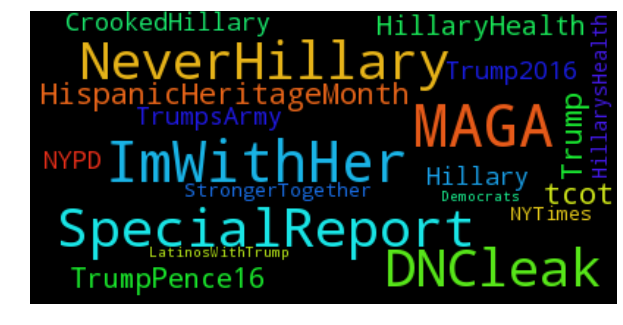

In [44]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Top hashtags plot

c = Counter(hashtags)
# plot wordcloud; words size is based on the frequency of each word
wordcloud = WordCloud(relative_scaling=0.2, background_color='black',stopwords=stopwords,max_font_size=40
                         ).generate_from_frequencies(c.most_common()[:20])

plt.figure().set_size_inches(10.5, 15.5)
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

* ------------------------

# Problem 3: Getting "All" friends and "All" followers of a popular user in twitter


* choose a popular twitter user who has many followers, such as "ladygaga".
* Get the list of all friends and all followers of the twitter user.
* Plot 20 out of the followers, plot their ID numbers and screen names in a table.
* Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.

In [15]:
#definitios and config values

api = tweepy.API(auth)

MANGODB_SERVER = 'ds035816.mlab.com'
MANGODB_PORT = 35816
MANGODB_CLINTON_FF_DB_NAME = "clintonff"
MANGODB_CLINTON_FF_COLL = "collection"
db_clinton_ff_client = pymongo.MongoClient(MANGODB_SERVER, MANGODB_PORT)
db_clinton_ff = db_clinton_ff_client[MANGODB_CLINTON_FF_DB_NAME]
db_clinton_ff.authenticate(MANGODB_USER, MANGODB_PASS)  
 

True

In [16]:
# fetch all followers 
import time
data_followers = {}
data_followers['type'] = 'followers'
data_followers['lst'] = []

while True:
    try:
        data_followers['lst'] = cur.next()[:]
        followers_json = json.loads(json.dumps(data_followers))
        db_clinton_ff[MANGODB_CLINTON_FF_COLL].insert_one(followers_json)
        del data_followers['lst'][:]     
    except tweepy.TweepError:
        # sleep for 15 mintues and then try again after the rate limit is released
        time.sleep(60 * 15 + 10)
        continue
    except StopIteration:
        break
        
print("done")

done


In [17]:
# fetch all friends
#no need for iteration like fetching followers as number of friends is relatvely small
data_friends = {}
data_friends['type'] = 'friends'
data_friends['lst'] = []

# fetch all friends list - as this list relativly samll we won't hit the limit here.

friends_ids = []     
for itm in tweepy.Cursor(api.friends_ids, id = 'HillaryClinton').items():
    data_friends['lst'].append(itm)

# save the friend's list in mangoDB    
friends_json = json.loads(json.dumps(data_friends))  
db_clinton_ff[MANGODB_CLINTON_FF_COLL].insert_one(friends_json)

In [16]:
# Given a set of user ids, this function calls get_screen_names and plots a table of the first (max_ids) ID's and screen names.
def draw_pretty_table(ids):
    users = api.lookup_users(user_ids=ids)
    pretty_table = PrettyTable(['ID','Screen Name'])
    [pretty_table.add_row ([row.id,row.screen_name]) for row in users]
    pretty_table.align = 'l'
    print(pretty_table)

In [19]:
# print 20 firends and 20 followers data
#
cursor = db_clinton_ff[MANGODB_CLINTON_FF_COLL].find({"type": "friends"})
print ("\n20 friends of Hilary Clinton\n")
draw_pretty_table(cursor[0]['lst'][:20])

cursor = db_clinton_ff[MANGODB_CLINTON_FF_COLL].find({"type": "followers"})
print ("\n20 followers of Hilary Clinton\n")
draw_pretty_table(cursor[0]['lst'][:20])
    


20 friends of Hilary Clinton

+--------------------+----------------+
| ID                 | Screen Name    |
+--------------------+----------------+
| 571202103          | Medium         |
| 21337440           | ChildDefender  |
| 23449384           | amberdiscko    |
| 128790234          | Samynemir      |
| 1656913327         | sarajacobs89   |
| 325886383          | SammyKoppelman |
| 802430450          | Natasha_S_Law  |
| 729761993461248000 | ktvibbs        |
| 115740215          | SarahAudelo    |
| 34782406           | Lincoln_Ross   |
| 3044781131         | HillaryforAR   |
| 113298560          | GunaRockYa     |
| 15972271           | CdotDukes      |
| 582037089          | MiguelAyala312 |
| 734768872625188864 | AndrewBatesNC  |
| 41021335           | TroyClair      |
| 4736170399         | BrianZuzenak   |
| 150885854          | SarahPeckVA    |
| 231673             | yianni         |
| 125083946          | GillDrummond   |
+--------------------+----------------+

20 follo

* Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table

In [20]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

cursor = db_clinton_ff[MANGODB_CLINTON_FF_COLL].find({"type": "friends"})
friends = cursor[0]['lst']
cursor = db_clinton_ff[MANGODB_CLINTON_FF_COLL].find({"type": "followers"})

# we have 1 list of friends (~800 members) and over 500 list of followers; each of 5000 members,
#iterate over the followers and build the intersaction list
common_friends = []
total = 0
for follower in cursor:
    common_friends.extend(set(friends).intersection(follower['lst']))
    total += len(follower['lst'])
    
#print ('Clinton has {} followers; {} following ; {} mutal friends'.format(total, len(friends), len(common_friends)))
print("This list is not a complete one as it requires about 30 hours to fetch all followers of \n Clinto due to twitter rate limit\n we fetched about 4M out of 8M followers\n")
print ("Mutual Friends table")
draw_pretty_table(common_friends)

This list is not a complete one as it requires about 30 hours to fetch all followers of 
 Clinto due to twitter rate limit
 we fetched about 4M out of 8M followers

Mutual Friends table
+--------------------+-----------------+
| ID                 | Screen Name     |
+--------------------+-----------------+
| 3068729259         | HillaryforND    |
| 3065862285         | HillaryforNJ    |
| 172858784          | timkaine        |
| 3064597541         | HillaryforMO    |
| 3044781131         | HillaryforAR    |
| 3073392597         | HillaryforSD    |
| 3078554829         | HillaryforTX    |
| 3057577828         | HillaryforIN    |
| 3073477156         | HillaryforTN    |
| 99545933           | mouto77         |
| 3086798481         | HillaryforWV    |
| 3044746419         | HillaryforCA    |
| 3047899581         | HillaryforCT    |
| 758346398156881920 | HRCforRI        |
| 3060191026         | HillaryforMA    |
| 3057542915         | HillaryforKY    |
| 3048168670         | HillaryforDE

*------------------------

# Problem 4: Business question 

Run some additional experiments with your data to gain familiarity with the twitter data and twitter API.

* Come up with a business question that Twitter data could help answer.
* Decribe the business case.
* How could Twitter data help a company decide how to spend its resources.

Even without complicated analysis twitter can yield impactful results about campaigns.  The 2016 presidential primaries could have been predicted by the amount of tweets about each candidate from the top six news networks (Simms).  With more complicated analyses, information gathered from tweets can not only predict but also guide political campaigns.  As such, campaign managers should take advantage of the information captured by Twitter.

Twitter could campaign managers in evaluation the effective of campaign, figure out the concerns of the public in each and different state, find out what top concerns of people against or pro Clinton (analyzing frequency table and top hashtage in positive and negative tweets)


First step will be classifiying the tweets to positive and negative, for that we will leverage the http://text-processing.com/ NLTK algorithm and run it on the tweet text

In [7]:
from urllib.parse import urlencode
from urllib.request import Request, urlopen
import json

sentiment_collection = db['sentiment']

cursor = tweets_Collection.find()

for document in cursor:
    
    screen_names = [ user_mention['screen_name']
        for user_mention in document['entities']['user_mentions'] ]
    # exclude tweets that mention both  realDonaldTrump and clinton from sentiment analysis.
    # trying to associate postive/negative in such tweets to clinton or trump is byond this scope of this case.
    if 'realDonaldTrump' in screen_names:
        continue

    # Iterate over the cleaned data - and process sentiment analysis on it. 
    url = 'https://japerk-text-processing.p.mashape.com/sentiment/' # Set destination URL here
    post_fields = {'language': 'english', 'text' : document['text']}     # Set POST fields here

    request = Request(url, urlencode(post_fields).encode())
    # I put my credit card in this website - first 40000 calls are free - DONT EXCEED 
    request.add_header('X-Mashape-Key', '1z19gbsrAwmsh1EqYI3CcBbNtjOSp1T1iVIjsnRoFmszvbDkNV')
    request.add_header('Content-Type', 'application/x-www-form-urlencoded')
    request.add_header('Accept', 'application/json')
    data = urlopen(request).read().decode()
    datajson = json.loads(data)
    sentiment_t = {}
    if document['place']:
        place = document['place']['full_name'].split()
        sentiment_t['state'] = place[(len(place) - 1)]
    sentiment_t['text'] = document['text']
    sentiment_t['sentiment_label'] = datajson['label']
    sentiment_t['entities'] = document['entities']
    sentiment_json = json.loads(json.dumps(sentiment_t))
    sentiment_collection.insert_one(sentiment_json)

print ("done")   

done


In [8]:
# print sumber of postive/negative postive ratio per state
fields=['state', 'Postive ratio', 'Negative ratio']
pt = PrettyTable(fields)
pt.aligns = ['l' for f in fields]

states_positive_ratio = {}
sentiment_collection = db['sentiment']

for state in us_states:
    row = []
    pos_count = sentiment_collection.find({'sentiment_label': 'pos', 'state':state}).count()
    neg_count = sentiment_collection.find({'sentiment_label': 'neg', 'state':state}).count()
    pos_ratio = 0
    neg_ratio = 0
    if pos_count + neg_count > 0:
        pos_ratio = pos_count / (pos_count + neg_count) * 100
        neg_ratio = neg_count / (pos_count + neg_count) * 100
    row.append(state)
    row.append("%.2f" % pos_ratio)
    row.append("%.2f" % neg_ratio)
    states_positive_ratio[state] = pos_ratio
    pt.add_row(row)
print(pt)   

+-------+---------------+----------------+
| state | Postive ratio | Negative ratio |
+-------+---------------+----------------+
|   WA  |     40.00     |     60.00      |
|   DE  |      0.00     |      0.00      |
|   WI  |      0.00     |      0.00      |
|   WV  |      0.00     |      0.00      |
|   HI  |      0.00     |      0.00      |
|   FL  |     28.57     |     71.43      |
|   WY  |      0.00     |      0.00      |
|   NH  |      0.00     |      0.00      |
|   NJ  |     45.45     |     54.55      |
|   NM  |     37.50     |     62.50      |
|   TX  |     57.89     |     42.11      |
|   LA  |      0.00     |     100.00     |
|   NC  |      0.00     |     100.00     |
|   ND  |      0.00     |      0.00      |
|   NE  |      0.00     |      0.00      |
|   TN  |      0.00     |     100.00     |
|   NY  |     38.89     |     61.11      |
|   PA  |     63.64     |     36.36      |
|   CA  |     45.00     |     55.00      |
|   NV  |      0.00     |     100.00     |
|   VA  |  

In [17]:
import folium
import pandas as pd
from IPython.display import HTML
from base64 import b64encode
%matplotlib inline

state_geo = r'us-states.json'

sentiment_collection = db['sentiment']
states_positive_ratio = {}
for state in us_states:
    pos_count = sentiment_collection.find({'sentiment_label': 'pos', 'state':state}).count()
    neg_count = sentiment_collection.find({'sentiment_label': 'neg', 'state':state}).count()
    pos_ratio = 0
    if pos_count + neg_count > 0:
        pos_ratio = pos_count / (pos_count + neg_count) * 100
    states_positive_ratio[state] = pos_ratio

map_data = states_positive_ratio

map = folium.Map(location=(39, -100), zoom_start=4)
#map = folium.Map(location=[48, -102], zoom_start=3)
map.choropleth(geo_path=state_geo, data=map_data,
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.8, line_opacity=0.6,
             reset=False)
print ("the map should be shown below; if you can't see it, please find it in DS501map.html or re-run the first cell and the cell above")
map.save("DS501map.html")
HTML(map._repr_html_())

the map should be shown below; if you can't see it, please find it in DS501map.html or re-run the first cell and the cell above


In [10]:
## TODO use top entites defined in 2.3
def print_top_hashtages(label, tweets, max_to_show):
    
    hashtags = [ hashtag['text'] 
         for tweet in tweets
             for hashtag in tweet['entities']['hashtags'] ]
    pt = PrettyTable(field_names=[label, 'Count'])
    c = Counter(hashtags)
    [ pt.add_row(kv) for kv in c.most_common()[:max_to_show] ]
    pt.align[label], pt.align['Count'] = 'l', 'r' # Set column alignment
    print(pt)

In [12]:
# print top hastages in postive, negative and netural tweets

sentiment_collection = db['sentiment']
cursor = sentiment_collection.find({'sentiment_label': 'pos'})
print_top_hashtages('Top Hashtage in POSTIVE Tweets', cursor, 20)

cursor = sentiment_collection.find({'sentiment_label': 'neg'})
print_top_hashtages('Top Hashtagein NEGATIVE Tweets', cursor, 20)

cursor = sentiment_collection.find({'sentiment_label': 'neutral'})
print_top_hashtages('Top Hashtage in NEUTRAL Tweets', cursor, 20)

+--------------------------------+-------+
| Top Hashtage in POSTIVE Tweets | Count |
+--------------------------------+-------+
| HispanicHeritageMonth          |   118 |
| ImWithHer                      |   107 |
| MAGA                           |    72 |
| tcot                           |    65 |
| Democrats                      |    50 |
| RedNationRising                |    46 |
| WakeUpAmerica                  |    43 |
| NeverHillary                   |    32 |
| HillaryClinton                 |    31 |
| Hillary                        |    30 |
| DNCLeak                        |    30 |
| DNCLeaks                       |    28 |
| Trump                          |    27 |
| ThursdayThoughts               |    27 |
| TheFive                        |    23 |
| Trump2016                      |    22 |
| ImInHer                        |    22 |
| nvdemsleak                     |    22 |
| HillarysHealth                 |    22 |
| TrumpPence16                   |    21 |
+----------

analyzing the hashtags distribution between positive and negative We find out that our sentiment NLP algorithm is not well trained - we need to train it again by using part of our data. We could prepare this training set by classifying positive or negative for the training set based on hashtags.
For that we decide the make another positive\negative analysis based on selection set of hashtags from the top ones, this tweets would be used as training set for the NLP algorithm.  due to time constraints, in the scope of this case we will use this subset small test training as our data for the next few steps  without re-training the NLP and running it again.


In [5]:
postive_hashtags = [item.lower() for item in ['ImWithHer','TurnNCBlue','StrongerTogether']]
negative_hashtags = [item.lower() for item in['WakeUpAmerica','NeverHillary','MAGA','CrookedHillary','AmericansUnitedForTrump']]

# tweet that had both postive_hashtags & negative_hashtags will be ignored.
# print top frequency words with postive_hashtags

cursor = tweets_Collection.find()
positive_tweets = []
negative_tweets = []
for document in cursor:
    hashtags = [ hashtag['text'].lower() 
         for hashtag in document['entities']['hashtags'] ]
    pos_count = len(set(postive_hashtags).intersection(hashtags))
    neg_count = len(set(negative_hashtags).intersection(hashtags))
    if (pos_count == 0 and neg_count == 0) or (pos_count > 0 and neg_count > 0):
        continue
    elif pos_count > 0:
        positive_tweets.append(document)
        #db['pos_version_b'].insert_one(document)
    else :
        #db['neg_version_b'].insert_one(document)
        negative_tweets.append(document)
        
print(len(positive_tweets))
print(len(negative_tweets))

385
732


In [11]:
# print top hashtags for VERSION B postive/negative tweets

print("These tables for verification only; not that informatic as the classification based on hashtags but it shows the popularity of these tags")
print_top_hashtages('Top Hashtagein POSITIVE Tweets - VERSION B', positive_tweets, 20)
print_top_hashtages('Top Hashtage in NEGATIVE Tweets - VERSION B', negative_tweets, 20)


These tables for verification only; not that informatic as the classification based on hashtags but it shows the popularity of these tags
+--------------------------------------------+-------+
| Top Hashtagein POSITIVE Tweets - VERSION B | Count |
+--------------------------------------------+-------+
| ImWithHer                                  |   293 |
| StrongerTogether                           |    78 |
| Hillary2016                                |    38 |
| GOPdebate                                  |    25 |
| imwithher                                  |    23 |
| TurnNCBlue                                 |    23 |
| Vote                                       |    14 |
| CHCI                                       |    11 |
| UniteBlue                                  |     8 |
| NeverTrump                                 |     8 |
| womenrights                                |     8 |
| ImWithThem                                 |     8 |
| HillaryClinton                     

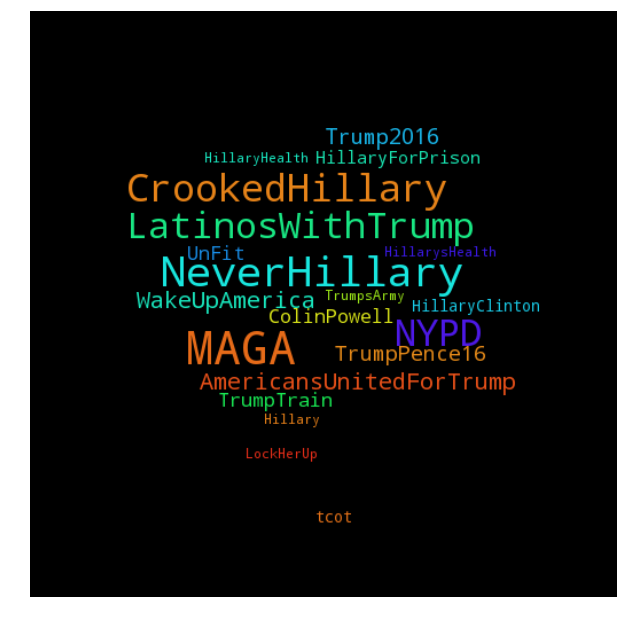

In [39]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Top negative wordcloud plot

hashtags = [ hashtag['text'] 
     for tweet in negative_tweets
         for hashtag in tweet['entities']['hashtags'] ]

c = Counter(hashtags)
    
up_mask = np.array(Image.open("down.png"))

stopwords = list(STOPWORDS)
stopwords.extend(["rt","another","wants","noun.","take","good","let's"])

wordcloud = WordCloud(relative_scaling=0.2, mask=up_mask, background_color='black',stopwords=stopwords,max_font_size=40
                         ).generate_from_frequencies(c.most_common()[:20])


plt.figure().set_size_inches(10.5, 10.5)
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

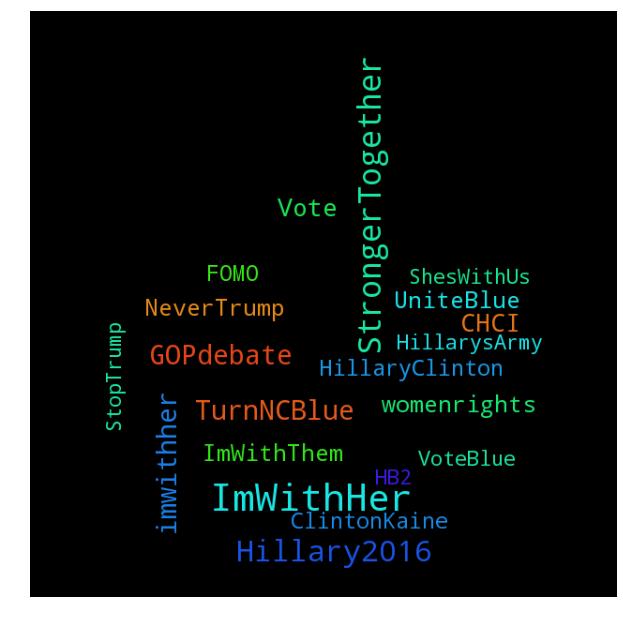

In [40]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Top positive wordcloud plot

hashtags = [ hashtag['text'] 
     for tweet in positive_tweets
         for hashtag in tweet['entities']['hashtags'] ]

c = Counter(hashtags)
    
up_mask = np.array(Image.open("up.jpg"))

stopwords = list(STOPWORDS)
stopwords.extend(["rt","another","wants","noun.","take","good","let's"])

wordcloud = WordCloud(relative_scaling=0.2, mask=up_mask, background_color='black',stopwords=stopwords,max_font_size=40
                         ).generate_from_frequencies(c.most_common()[:20])


plt.figure().set_size_inches(10.5, 10.5)
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [29]:
# most common words in positive and negative

from nltk.corpus import stopwords
stopwords = list(stopwords.words('english'))
stopwords.extend(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}']) 


positive_texts = [tweet['text'] 
                 for tweet in positive_tweets ]

positive_words = [ w.lower()
          for t in positive_texts 
              for w in t.split() ]

positive_words = [w for w in positive_words if w not in stopwords and not w.startswith(("http","#","@","&"))]

negative_texts = [tweet['text'] 
                 for tweet in negative_tweets ]
negative_words = [ w.lower() 
          for t in negative_texts 
              for w in t.split() ]

negative_words = [w for w in negative_words if w not in stopwords and not w.startswith(("http","#","@","&"))]

print_top_entities("most frequent words in POSITIVE tweets - VERSION B", positive_words, 20)
print_top_entities("most frequent words in NEGATIVE tweets - VERSION B", negative_words, 20) 
    

+----------------------------------------------------+-------+
| most frequent words in POSITIVE tweets - VERSION B | Count |
+----------------------------------------------------+-------+
| rt                                                 |   205 |
| speech                                             |    36 |
| need                                               |    31 |
| .@hillaryclinton                                   |    24 |
| real                                               |    24 |
| minutes.                                           |    24 |
| here's                                             |    23 |
| nc?                                                |    23 |
| missed                                             |    23 |
| 3                                                  |    23 |
| everything                                         |    23 |
| back                                               |    18 |
| i'm                                                | 

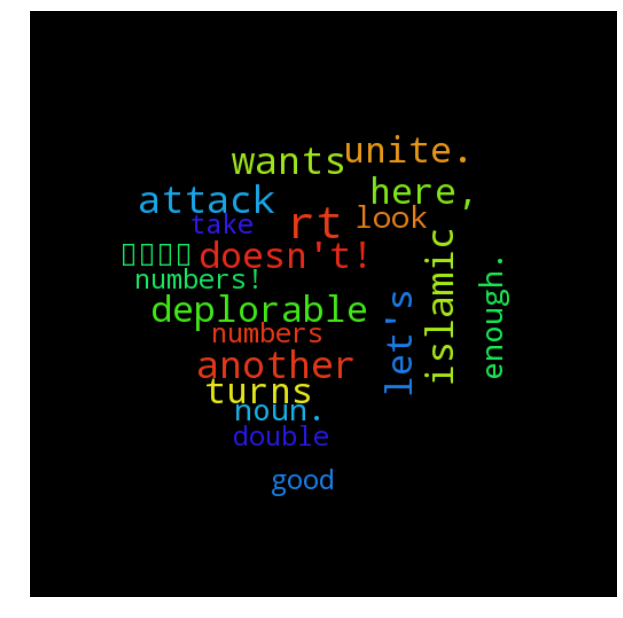

In [32]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Top negative wordcloud plot
c = Counter(negative_words)

up_mask = np.array(Image.open("down.png"))

stopwords = list(STOPWORDS)
stopwords.extend(["rt","another","wants","noun.","take","good","let's"])

wordcloud = WordCloud(relative_scaling=0.2, mask=up_mask, background_color='black',stopwords=stopwords,max_font_size=40
                         ).generate_from_frequencies(c.most_common()[:20])


plt.figure().set_size_inches(10.5, 10.5)
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

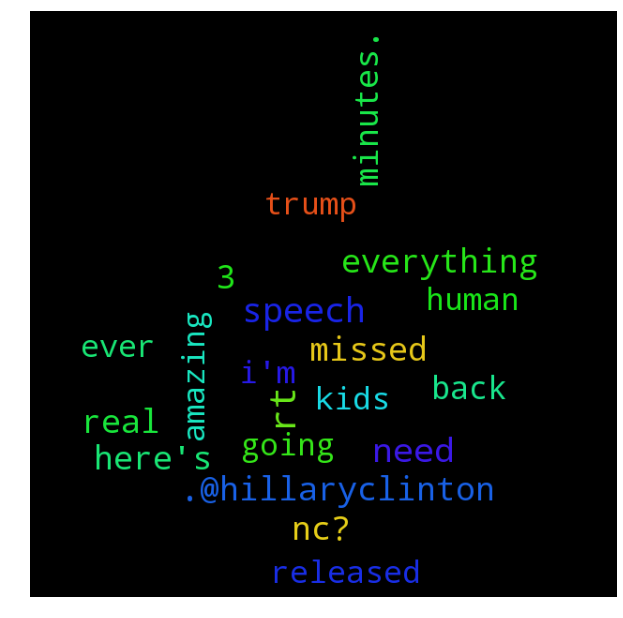

In [38]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# Top postive wordcloud plot
c = Counter(positive_words)

up_mask = np.array(Image.open("up.jpg"))

stopwords = list(STOPWORDS)
stopwords.extend(["rt","minutes.","here's","i'm"])

wordcloud = WordCloud(relative_scaling=0.1, mask=up_mask, background_color='black',stopwords=stopwords,max_font_size=40
                         ).generate_from_frequencies(c.most_common()[:20])


plt.figure().set_size_inches(10.5, 10.5)
plt.imshow(wordcloud, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

lets calculate postive ratio per state and draw the map again to compare it with the map form the NLP classification

In [18]:
#lets calculate postive ratio per state and draw the map again to compare it with the map form the NLP classification
us_states_positive = {"WA"  : 0, "DE"  : 0, "WI"  : 0, "WV"  : 0, "HI"  : 0, "FL"  : 0, "WY"  : 0, "NH"  : 0, "NJ"  : 0, "NM"  : 0, "TX"  : 0, "LA"  : 0, "NC"  : 0, "ND"  : 0, "NE"  : 0, "TN"  : 0, "NY"  : 0, "PA"  : 0, "CA"  : 0, "NV"  : 0, "VA"  : 0, "CO"  : 0, "AK"  : 0, "AL"  : 0, "AR"  : 0, "VT"  : 0, "IL"  : 0, "GA"  : 0, "IN"  : 0, "IA"  : 0, "OK"  : 0, "AZ"  : 0, "ID"  : 0, "CT"  : 0, "ME"  : 0, "MD"  : 0, "MA"  : 0, "OH"  : 0, "UT"  : 0, "MO"  : 0, "MN"  : 0, "MI"  : 0, "RI"  : 0, "KS"  : 0, "MT"  : 0, "MS"  : 0, "SC"  : 0, "KY"  : 0, "OR"  : 0, "SD" :0, "USA":0 } 
us_states_nagative = {"WA"  : 0, "DE"  : 0, "WI"  : 0, "WV"  : 0, "HI"  : 0, "FL"  : 0, "WY"  : 0, "NH"  : 0, "NJ"  : 0, "NM"  : 0, "TX"  : 0, "LA"  : 0, "NC"  : 0, "ND"  : 0, "NE"  : 0, "TN"  : 0, "NY"  : 0, "PA"  : 0, "CA"  : 0, "NV"  : 0, "VA"  : 0, "CO"  : 0, "AK"  : 0, "AL"  : 0, "AR"  : 0, "VT"  : 0, "IL"  : 0, "GA"  : 0, "IN"  : 0, "IA"  : 0, "OK"  : 0, "AZ"  : 0, "ID"  : 0, "CT"  : 0, "ME"  : 0, "MD"  : 0, "MA"  : 0, "OH"  : 0, "UT"  : 0, "MO"  : 0, "MN"  : 0, "MI"  : 0, "RI"  : 0, "KS"  : 0, "MT"  : 0, "MS"  : 0, "SC"  : 0, "KY"  : 0, "OR"  : 0, "SD" :0, "USA":0} 
us_states_ratio =    {"WA"  : 0, "DE"  : 0, "WI"  : 0, "WV"  : 0, "HI"  : 0, "FL"  : 0, "WY"  : 0, "NH"  : 0, "NJ"  : 0, "NM"  : 0, "TX"  : 0, "LA"  : 0, "NC"  : 0, "ND"  : 0, "NE"  : 0, "TN"  : 0, "NY"  : 0, "PA"  : 0, "CA"  : 0, "NV"  : 0, "VA"  : 0, "CO"  : 0, "AK"  : 0, "AL"  : 0, "AR"  : 0, "VT"  : 0, "IL"  : 0, "GA"  : 0, "IN"  : 0, "IA"  : 0, "OK"  : 0, "AZ"  : 0, "ID"  : 0, "CT"  : 0, "ME"  : 0, "MD"  : 0, "MA"  : 0, "OH"  : 0, "UT"  : 0, "MO"  : 0, "MN"  : 0, "MI"  : 0, "RI"  : 0, "KS"  : 0, "MT"  : 0, "MS"  : 0, "SC"  : 0, "KY"  : 0, "OR"  : 0, "SD" :0, "USA":0} 

crusor = db['pos_version_b'].find()
for document in crusor:
    if document['place']:
        place = document['place']['full_name'].split()
        state = place[(len(place) - 1)]
        us_states_positive[state] = us_states_positive[state] + 1 

crusor = db['neg_version_b'].find()
for document in crusor:
    if document['place']:
        place = document['place']['full_name'].split()
        state = place[(len(place) - 1)]
        us_states_nagative[state] = us_states_positive[state] + 1 

for state in us_states:
    if us_states_positive[state] + us_states_nagative[state] != 0:
        us_states_ratio[state] = 100 * us_states_positive[state] / (us_states_positive[state] + us_states_nagative[state] )

map_data = us_states_ratio

map = folium.Map(location=(39, -100), zoom_start=4)
#map = folium.Map(location=[48, -102], zoom_start=3)
map.choropleth(geo_path=state_geo, data=map_data,
             key_on='feature.id',
             fill_color='BuPu', fill_opacity=0.8, line_opacity=0.6,
             reset=False)
print ("the map should be shown below; if you can't see it, please find it in DS501map_ver_b.html or re-run the first cell and the cell above")
map.save("DS501map_ver_b.html")
print("As number of tweets we classify by tag and has geo info is very small (less than 20) many states are with ratio 0; there is a need to collect more data")
HTML(map._repr_html_())

the map should be shown below; if you can't see it, please find it in DS501map_ver_b.html or re-run the first cell and the cell above
As number of tweets we classify by tag and has geo info is very small (less than 20) many states are with ratio 0; there is a need to collect more data


*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "ipython notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.


* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . We will ask two teams which are randomly selected to present their case studies in class for this case study. 

* ** Report**: please prepare a report (less than 10 pages) to report what you found in the data.
    * What data you collected? 
    * Why this topic is interesting or important to you? (Motivations)
    * How did you analyse the data?
    * What did you find in the data? 
 
     (please include figures or tables in the report, but no source code)

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through email to Prof. Paffenroth (rcpaffenroth@wpi.edu) *and* the TA Wen Liu (wliu3@wpi.edu).
        
** Note: Each team just needs to submits one submission **

# Grading Criteria:

** Totoal Points: 120 **


---------------------------------------------------------------------------
** Notebook:  **
    Points: 80


    -----------------------------------
    Qestion 1:
    Points: 20
    -----------------------------------
    
    (1) Select a topic that you are interested in.
    Points: 6 
    
    (2) Use Twitter Streaming API to sample a collection of tweets about this topic in real time. (It would be recommended that the number of tweets should be larger than 200, but smaller than 1 million. Please check whether the total number of tweets collected is larger than 200?
    Points: 10 
    
    
    (3) Store the tweets you downloaded into a local file (txt file or json file)
    Points: 4 
    
    
    -----------------------------------
    Qestion 2:
    Points: 20
    -----------------------------------
    
    1. Word Count

    (1) Use the tweets you collected in Problem 1, and compute the frequencies of the words being used in these tweets.
    Points: 4 

    (2) Plot a table of the top 30 words with their counts 
    Points: 4 
    
    2. Find the most popular tweets in your collection of tweets
    plot a table of the top 10 tweets that are the most popular among your collection, i.e., the tweets with the largest number of retweet counts.
    Points: 4 
    
    3. Find the most popular Tweet Entities in your collection of tweets

    (1) plot a table of the top 10 hashtags, 
    Points: 4 

    (2) top 10 user mentions that are the most popular in your collection of tweets.
    Points: 4 
    
    
    -----------------------------------
    Qestion 3:
    Points: 20
    -----------------------------------
    
    (1) choose a popular twitter user who has many followers, such as "ladygaga".
    Points: 4 

    (2) Get the list of all friends and all followers of the twitter user.
    Points: 4 

    (3) Plot 20 out of the followers, plot their ID numbers and screen names in a table.
    Points: 4 

    (4) Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.
    Points: 4 
    
    (5) Compute the mutual friends within the two groups, i.e., the users who are in both friend list and follower list, plot their ID numbers and screen names in a table
    Points: 4 
  
    -----------------------------------
    Qestion 4:  Business question
    Points: 20
    -----------------------------------
        Novelty: 10
        Interestingness: 10
    -----------------------------------
    Run some additional experiments with your data to gain familiarity with the twitter data ant twitter API.  Come up with a business question and describe how Twitter data can help you answer that question.




---------------------------------------------------------------------------
** Report: communicate the results**
    Points: 20

(1) What data you collected?
    Points: 5 

(2) Why this topic is interesting or important to you? (Motivations)
    Points: 5 

(3) How did you analyse the data?
    Points: 5 

(4) What did you find in the data?
(please include figures or tables in the report, but no source code)
    Points: 5 



---------------------------------------------------------------------------
** Slides (for 10 minutes of presentation): Story-telling **
    Points: 20


1. Motivation about the data collection, why the topic is interesting to you.
    Points: 5 

2. Communicating Results (figure/table)
    Points: 10 

3. Story telling (How all the parts (data, analysis, result) fit together as a story?)
    Points: 5 

